In [14]:
import numpy as np
from scipy.spatial import Delaunay, KDTree
import matplotlib.pyplot as plt
import math
from collections import defaultdict

def euclidean_distance(point_a, point_b):
    """
    Calculate the Euclidean distance between two points.
    :param point_a: First point.
    :param point_b: Second point.
    :return: Euclidean distance between the two points.
    """
    return np.linalg.norm(point_a - point_b)

# Step 1: Preprocess the core data
def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    coordinates = np.array([(core['x'], core['y']) for core in cores])
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array([(x - min_x, max_y - y) for x, y in coordinates])
    return normalized_inverted_coordinates

import numpy as np
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans

# Step 1: Perform Delaunay triangulation and get all edges
def get_all_edges_from_triangulation(triangulation):
    edges = set()
    # For each triangle, add edges to the set, avoiding duplicates
    for simplex in triangulation.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            edges.add(edge)
    return np.array(list(edges))


# Step 2: Delaunay triangulation
def delaunay_triangulation(coordinates):
    """
    Perform Delaunay triangulation on the coordinates.
    :param coordinates: Array of coordinates.
    :return: Delaunay object containing the triangulation.
    """
    return Delaunay(coordinates)

# # Step 2: Edge length filtering function
# def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
#     edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
#     edge_lengths = np.array(edge_lengths)
    
#     Q1, Q3 = np.percentile(edge_lengths, [25, 75])
#     IQR = Q3 - Q1
#     lower_bound = Q1 - (threshold_multiplier * IQR)
#     upper_bound = Q3 + (threshold_multiplier * IQR)

#     # We don't care about getting rid of all the short edges, just the really long ones
#     # filtered_edges = edges[(edge_lengths <= upper_bound)]
#     filtered_edges = edges[(edge_lengths >= lower_bound) & (edge_lengths <= upper_bound)]
    

#     return filtered_edges

def calculate_edge_lengths(edges, coordinates):
    return np.array([np.linalg.norm(coordinates[start] - coordinates[end]) for start, end in edges])

def calculate_mad_bounds(edge_lengths, threshold_multiplier):
    median = np.median(edge_lengths)
    mad = np.median(np.abs(edge_lengths - median))
    lower_bound = median - (threshold_multiplier * mad)
    upper_bound = median + (threshold_multiplier * mad)
    return lower_bound, upper_bound

def filter_edges_within_bounds(edges, edge_lengths, lower_bound, upper_bound):
    return [edge for edge, length in zip(edges, edge_lengths) if length <= upper_bound]

def order_edges_to_point_right(filtered_edges, coordinates):
    return [(end, start) if coordinates[start][0] > coordinates[end][0] else (start, end) for start, end in filtered_edges]

def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
    edge_lengths = calculate_edge_lengths(edges, coordinates)
    lower_bound, upper_bound = calculate_mad_bounds(edge_lengths, threshold_multiplier)
    filtered_edges = filter_edges_within_bounds(edges, edge_lengths, lower_bound, upper_bound)
    ordered_edges = order_edges_to_point_right(filtered_edges, coordinates)
    return ordered_edges

# Step 3: Angle filtering function
# from sklearn.cluster import KMeans

# def filter_edges_by_angle(edges, coordinates, delta=0):
#     # Calculate edge angles and adjust by δ
#     angles = np.array([calculate_edge_angle(coordinates[edge[0]], coordinates[edge[1]])
#                        for edge in edges])
    
#     # Normalize angles to [0, 2*pi) and adjust by delta
#     angles = (angles + delta) % (2 * np.pi)
    
#     # Use k-means clustering to find clusters around expected angles

#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(angles.reshape(-1, 1))
    
#     # Determine which cluster corresponds to near-horizontal angles
#     # This requires examining the cluster centers and selecting the one closest to 0 + δ or π + δ
#     cluster_centers = kmeans.cluster_centers_.flatten()
#     horizontal_clusters = []
#     for expected_angle in [0, np.pi]:  # Horizontal angles adjusted by δ
#         adjusted_angle = (expected_angle + delta) % (2 * np.pi)
#         horizontal_clusters.append(np.argmin(np.abs(cluster_centers - adjusted_angle)))


#     # Filter edges based on their cluster label being one of the horizontal clusters
#     filtered_edge_indices = np.isin(kmeans.labels_.flatten(), horizontal_clusters)
#     filtered_edges = np.array(edges)[filtered_edge_indices]
    
#     return filtered_edges

def calculate_edge_angle(start_coord, end_coord):
    """
    Calculate the angle of an edge with respect to the x-axis.

    Parameters:
    start_coord (tuple): The starting coordinate of the edge.
    end_coord (tuple): The ending coordinate of the edge.

    Returns:
    float: The angle in degrees.
    """
    dx = end_coord[0] - start_coord[0]
    dy = end_coord[1] - start_coord[1]
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def filter_edges_by_angle(edges, coordinates, threshold_angle, origin_angle):
    """
    Filter edges based on their angle with respect to the x-axis.

    Parameters:
    edges (list of tuples): Indices of the edges.
    coordinates (dict): Coordinate values corresponding to the edge indices.
    threshold_angle (float): The +/- threshold angle from the origin angle.
    origin_angle (float): The angle around which the threshold is calculated.

    Returns:
    list: Filtered edges that fall within the specified angle range.
    """
    filtered_edges = []
    for start, end in edges:
        edge_angle = calculate_edge_angle(coordinates[start], coordinates[end])
        if origin_angle - threshold_angle <= edge_angle <= origin_angle + threshold_angle:
            filtered_edges.append((start, end))

    return filtered_edges

def limit_connections(edges, coordinates):
    """
    Limits each point's connections to at most one closest point in each direction based on the shortest distance.
    Ensures that the connection is mutual and directional criteria are met.
    """
    # Step 1: Calculate distances for all connections
    all_connections = defaultdict(list)
    for edge in edges:
        point_a, point_b = edge
        distance = np.linalg.norm(coordinates[point_a] - coordinates[point_b])
        all_connections[point_a].append((point_b, distance))
        all_connections[point_b].append((point_a, distance))

    # Step 2: Sort connections for each point
    for point, connections in all_connections.items():
        connections.sort(key=lambda x: x[1])

    # Step 3: Select the closest point in each direction mutually
    mutual_connections = defaultdict(dict)
    for point, connections in all_connections.items():
        for connected_point, distance in connections:
            if coordinates[connected_point][0] < coordinates[point][0]:  # Connected point is to the left
                if 'left' not in mutual_connections[point] or distance < mutual_connections[point]['left'][1]:
                    mutual_connections[point]['left'] = (connected_point, distance)
            elif coordinates[connected_point][0] > coordinates[point][0]:  # Connected point is to the right
                if 'right' not in mutual_connections[point] or distance < mutual_connections[point]['right'][1]:
                    mutual_connections[point]['right'] = (connected_point, distance)

    # Step 4: Confirm the directionality is mutual
    final_edges = set()
    for point, directions in mutual_connections.items():
        for direction, (connected_point, _) in directions.items():
            opposite_direction = 'left' if direction == 'right' else 'right'
            if mutual_connections.get(connected_point, {}).get(opposite_direction, (None,))[0] == point:
                final_edges.add((min(point, connected_point), max(point, connected_point)))

    # Return the list of final edges
    return list(final_edges)


In [16]:
import numpy as np
from scipy.spatial import Delaunay, KDTree
import matplotlib.pyplot as plt
import math
from collections import defaultdict

def euclidean_distance(point_a, point_b):
    """
    Calculate the Euclidean distance between two points.
    :param point_a: First point.
    :param point_b: Second point.
    :return: Euclidean distance between the two points.
    """
    return np.linalg.norm(point_a - point_b)

# Step 1: Preprocess the core data
def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    coordinates = np.array([(core['x'], core['y']) for core in cores])
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array([(x - min_x, max_y - y) for x, y in coordinates])
    return normalized_inverted_coordinates

import numpy as np
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans

# Step 1: Perform Delaunay triangulation and get all edges
def get_all_edges_from_triangulation(triangulation):
    edges = set()
    # For each triangle, add edges to the set, avoiding duplicates
    for simplex in triangulation.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            edges.add(edge)
    return np.array(list(edges))


# Step 2: Delaunay triangulation
def delaunay_triangulation(coordinates):
    """
    Perform Delaunay triangulation on the coordinates.
    :param coordinates: Array of coordinates.
    :return: Delaunay object containing the triangulation.
    """
    return Delaunay(coordinates)

# # Step 2: Edge length filtering function
# def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
#     edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
#     edge_lengths = np.array(edge_lengths)
    
#     Q1, Q3 = np.percentile(edge_lengths, [25, 75])
#     IQR = Q3 - Q1
#     lower_bound = Q1 - (threshold_multiplier * IQR)
#     upper_bound = Q3 + (threshold_multiplier * IQR)

#     # We don't care about getting rid of all the short edges, just the really long ones
#     # filtered_edges = edges[(edge_lengths <= upper_bound)]
#     filtered_edges = edges[(edge_lengths >= lower_bound) & (edge_lengths <= upper_bound)]
    

#     return filtered_edges

def calculate_edge_lengths(edges, coordinates):
    return np.array([np.linalg.norm(coordinates[start] - coordinates[end]) for start, end in edges])

def calculate_mad_bounds(edge_lengths, threshold_multiplier):
    median = np.median(edge_lengths)
    mad = np.median(np.abs(edge_lengths - median))
    lower_bound = median - (threshold_multiplier * mad)
    upper_bound = median + (threshold_multiplier * mad)
    return lower_bound, upper_bound

def filter_edgesz_within_bounds(edges, edge_lengths, lower_bound, upper_bound):
    return [edge for edge, length in zip(edges, edge_lengths) if length <= upper_bound]

def order_edges_to_point_right(filtered_edges, coordinates):
    return [(end, start) if coordinates[start][0] > coordinates[end][0] else (start, end) for start, end in filtered_edges]

def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
    edge_lengths = calculate_edge_lengths(edges, coordinates)
    lower_bound, upper_bound = calculate_mad_bounds(edge_lengths, threshold_multiplier)
    filtered_edges = filter_edges_within_bounds(edges, edge_lengths, lower_bound, upper_bound)
    ordered_edges = order_edges_to_point_right(filtered_edges, coordinates)
    return ordered_edges

# Step 3: Angle filtering function
# from sklearn.cluster import KMeans

# def filter_edges_by_angle(edges, coordinates, delta=0):
#     # Calculate edge angles and adjust by δ
#     angles = np.array([np.arctan2(coordinates[edge[1]][1] - coordinates[edge[0]][1], 
#                                    coordinates[edge[1]][0] - coordinates[edge[0]][0])
#                        for edge in edges])
    
#     # Normalize angles to [0, 2*pi) and adjust by delta
#     angles = (angles + delta) % (2 * np.pi)
    
#     # Use k-means clustering to find clusters around expected angles
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(angles.reshape(-1, 1))
    
#     # Determine which cluster corresponds to near-horizontal angles
#     # This requires examining the cluster centers and selecting the one closest to 0 + δ or π + δ
#     cluster_centers = kmeans.cluster_centers_.flatten()
#     horizontal_clusters = []
#     for expected_angle in [0, np.pi]:  # Horizontal angles adjusted by δ
#         adjusted_angle = (expected_angle + delta) % (2 * np.pi)
#         horizontal_clusters.append(np.argmin(np.abs(cluster_centers - adjusted_angle)))
    
#     # Filter edges based on their cluster label being one of the horizontal clusters
#     filtered_edge_indices = np.isin(kmeans.labels_.flatten(), horizontal_clusters)
#     filtered_edges = np.array(edges)[filtered_edge_indices]
    
#     return filtered_edges

def vector_angle(x, y):
    """
    Calculate the angle (in degrees) of a vector with respect to the x-axis.

    Parameters:
    x (float): The x-component of the vector.
    y (float): The y-component of the vector.

    Returns:
    float: The angle in degrees.
    """
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def calculate_edge_angle(start_coord, end_coord):
    """
    Calculate the angle of an edge with respect to the x-axis.

    Parameters:
    start_coord (tuple): The starting coordinate of the edge.
    end_coord (tuple): The ending coordinate of the edge.

    Returns:
    float: The angle in degrees.
    """
    dx = end_coord[0] - start_coord[0]
    dy = end_coord[1] - start_coord[1]
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def filter_edges_by_angle(edges, coordinates, threshold_angle, origin_angle):
    """
    Filter edges based on their angle with respect to the x-axis.

    Parameters:
    edges (list of tuples): Indices of the edges.
    coordinates (dict): Coordinate values corresponding to the edge indices.
    threshold_angle (float): The +/- threshold angle from the origin angle.
    origin_angle (float): The angle around which the threshold is calculated.

    Returns:
    list: Filtered edges that fall within the specified angle range.
    """
    filtered_edges = []
    for start, end in edges:
        edge_angle = calculate_edge_angle(coordinates[start], coordinates[end])
        if origin_angle - threshold_angle <= edge_angle <= origin_angle + threshold_angle:
            filtered_edges.append((start, end))

    return filtered_edges



In [17]:
import numpy as np
from collections import defaultdict


# Helper function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Helper function to normalize an angle between 0 and 360 degrees
def normalize_angle_degrees(angle):
    return angle % 360

def angle_with_x_axis(Vj, V_prime):
    """
    Calculate the angle (in degrees) between the vector from Vj to V_prime and the positive x-axis.
    V_prime and Vj are both numpy arrays or lists of length 2.
    """
    delta_x = V_prime[0] - Vj[0]
    delta_y = V_prime[1] - Vj[1]
    angle_radians = np.arctan2(delta_y, delta_x)  # arctan2 handles all quadrants
    angle_degrees = np.degrees(angle_radians)
    return normalize_angle_degrees(angle_degrees)

# Helper function to check if a point is within the circular sector
def point_in_sector(V_prime, Vj, r, phi=360, origin_angle=0):
    distance = calculate_distance(V_prime, Vj)
    if distance > r:
        return False  # The point is outside the sector's radius

    # For a full circle, any point within the radius should return True
    if phi == 360:
        return True

    # # Calculate the angle between Vj and V_prime relative to the x-axis
    # angle_Vj_V_prime = angle_with_x_axis(Vj, V_prime)  # Ensure this is in degrees

    # # Normalize angles
    # start_angle = normalize_angle_degrees(origin_angle - phi / 2)
    # end_angle = normalize_angle_degrees(origin_angle + phi / 2)
    # angle_Vj_V_prime = normalize_angle_degrees(angle_Vj_V_prime)

    # # Check if the angle is within the sector, considering the wrap-around case
    # if start_angle < end_angle:
    #     return start_angle <= angle_Vj_V_prime <= end_angle
    # else:
    #     return angle_Vj_V_prime >= start_angle or angle_Vj_V_prime <= end_angle
    


# Helper function to check if point is within the image width threshold
def is_close_to_image_width(point, image_width, gamma):
    return abs(point[0] - image_width) < gamma

# Main traveling algorithm
def traveling_algorithm(S, image_width, d, gamma, phi=180, origin_angle=0, radius_multiplier=0.5):
    A = []  # Final list of rows of centroids
    r = radius_multiplier * d  # Radius for sector search
    imaginary_points_index = -1  # Start an index for imaginary points

    # Ensure S is a list of dictionaries with 'start', 'end', 'index', and 'is_imaginary' keys
    S = [{'start': np.array(v[0]), 'end': np.array(v[1]), 'index': i, 'is_imaginary': False} for i, v in enumerate(S)]
    
    while S:
        # Find the start vector with the smallest x-coordinate in the first point of the vector
        start_vector = min(S, key=lambda v: v['start'][0])
        A1 = [start_vector]  # Start with the vector with the smallest x

        Vj = start_vector['end']  # Initialize previous_Vj and Vj with the endpoint of the start vector
        previous_Vj = None
        # Remove the start vector from S by filtering
        S = [vector for vector in S if vector['index'] != start_vector['index']]

        # Iterative Traveling
        first_imaginary = True
        while True:
            next_vector = next((v for v in S if np.allclose(v['start'], Vj, atol=1e-3)), None)
            if next_vector:
                previous_Vj = Vj  # Update previous_Vj before changing Vj
                Vj = next_vector['end']
                A1.append(next_vector)
                S = [vector for vector in S if vector['index'] != next_vector['index']]
                first_imaginary = True
            else:
                if not is_close_to_image_width(Vj, image_width, gamma):
                    # candidates = [v for v in S if point_in_sector(v['start'], Vj, r, phi, origin_angle)]
                    candidates = [v for v in S if point_in_sector(v['start'], Vj, r, phi, origin_angle)]

                    if candidates:
                        closest_vector = min(candidates, key=lambda v: calculate_distance(v['end'], Vj))
                        previous_Vj = Vj  # Update previous_Vj before changing Vj
                        Vj = closest_vector['end']
                        A1.append(closest_vector)
                        S = [vector for vector in S if vector['index'] != closest_vector['index']]
                        first_imaginary = True

                    else:
                        # Add an imaginary point to the right of the current point
                        delta_rad = np.radians(origin_angle)  # Angle for imaginary point is 0 radians
                        Vj_prime = np.array([Vj[0] + d * np.cos(delta_rad), Vj[1] + d * np.sin(delta_rad)])
                        imaginary_vector = {'start': Vj, 'end': Vj_prime, 'index': imaginary_points_index, 'is_imaginary': True}

                        # If it's the first point with is_imaginary == True in A1, then set 'is_imaginary' to False. 
                        # This is because the first imaginary point will start at the last real point in the row
                        if first_imaginary:
                            imaginary_vector['is_imaginary'] = False 
                            first_imaginary = False

                        imaginary_points_index -= 1  # Decrement to keep imaginary indices unique and negative
                        A1.append(imaginary_vector)
                        previous_Vj = Vj
                        Vj = Vj_prime
                        
                else:
                    
                    row = [{'point': vec['start'], 'index': vec['index'], 'is_imaginary': vec['is_imaginary']} for vec in A1]    
                    
                    # Remove duplicate points with the same 'point' key in the dictionary 
                    # Temporary dictionary to track seen points
                    seen_points = {}
                    # Filtered list for unique points
                    unique_row = []

                    for item in row:
                        point = tuple(item['point'])  # Convert numpy array to a tuple
                        if point not in seen_points:
                            seen_points[point] = True
                            unique_row.append(item)

                    A.append(unique_row)
                    if S:
                        break  # Exit the inner loop to start a new row
                    else:
                        return A  # If S is empty, we are done

        # Prepare for the next row
        A1 = []  # Clear A1 for the next row

    return A


In [18]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_delaunay_triangulation(coordinates, triangulation):
    plt.figure(figsize=(10, 10))
    plt.triplot(coordinates[:, 0], coordinates[:, 1], triangulation.simplices, color='grey', alpha=0.5)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Initial Delaunay Triangulation')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_length_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='blue', linewidths=1)
    
    plt.figure(figsize=(10, 10))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Length Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_angle_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='red', linewidths=1)
    
    plt.figure(figsize=(10, 10))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Angle Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_final_output(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='red', linewidths=1)
    
    plt.figure(figsize=(10, 10))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Number of connections limiting')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



def visualize_traveling_algorithm(coordinates, path):
    path_coords = coordinates[path]
    
    plt.figure(figsize=(10, 10))
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'o-', color='green')
    plt.title('Traveling Algorithm Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [32]:
import pandas as pd

def average_edge_length(vectors):
    # Create a dictionary to map the start and end points of each vector
    points_map = {}
    for start, end in vectors:
        if start in points_map:
            points_map[start].append(end)
        else:
            points_map[start] = [end]

        # Also map the end to start for bidirectional search
        if end in points_map:
            points_map[end].append(start)
        else:
            points_map[end] = [start]

    # Function to recursively find connected vectors
    def build_edge(start, visited):
        edge = [start]
        for end in points_map[start]:
            if end not in visited:
                visited.add(end)
                edge.extend(build_edge(end, visited))
        return edge

    # Find all edges
    all_edges = []
    visited = set()
    for start in points_map:
        if start not in visited:
            visited.add(start)
            edge = build_edge(start, visited)
            # Removing duplicates and maintaining order
            ordered_edge = []
            [ordered_edge.append(x) for x in edge if x not in ordered_edge]
            if len(ordered_edge) > 1 or ordered_edge[0] == ordered_edge[-1]:  # Include single point loops
                all_edges.append(tuple(ordered_edge))

    # Filter to keep only the longest edges that contain each vector
    final_edges = []
    for edge in all_edges:
        # Check if the edge or any of its subedges are already represented
        if not any(set(edge).issubset(set(existing_edge)) for existing_edge in final_edges):
            final_edges.append(edge)

    return np.mean([len(edge) for edge in final_edges])

def filter_edges(triangulation, normalized_coordinates, image_rotation, angle_threshold = 10):
  
    all_edges = get_all_edges_from_triangulation(triangulation)
    length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates, 1.5)
    angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, image_rotation, angle_threshold)
    traveling_algorithm_input = limit_connections(angle_filtered_edges, normalized_coordinates)

    # visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)
    # visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)
    # visualize_final_output(normalized_coordinates, traveling_algorithm_input)

    return traveling_algorithm_input


labels_path = './TMA_WSI_Labels_updated/62.json'
def determine_image_rotation(labels_path, min_angle, max_angle, angle_step_size, angle_threshold):

    data = pd.read_json(labels_path)
    cores = data.to_dict('records')
    normalized_coordinates = preprocess_cores(cores)
    triangulation = Delaunay(normalized_coordinates)
    
    best_edge_set = None
    best_edge_set_length = 0
    optimal_angle = min_angle
    
    for i in range(min_angle, max_angle, angle_step_size):   
        edges_set = filter_edges(triangulation, normalized_coordinates, i, angle_threshold)
        edges_set = sort_edges_and_add_isolated_points(edges_set, normalized_coordinates)
        set_length = average_edge_length(edges_set)
        if set_length > best_edge_set_length:
            best_edge_set_length = set_length
            best_edge_set = edges_set

            optimal_angle = i

    return best_edge_set, best_edge_set_length, optimal_angle

def sort_edges_and_add_isolated_points(best_edge_set, normalized_coordinates):
    sorted_edges = []
    for edge in best_edge_set:
        start, end = edge
        if normalized_coordinates[start][0] > normalized_coordinates[end][0]:
            # Swap the start and end points
            sorted_edges.append((end, start))
        else:
            sorted_edges.append((start, end))

    def is_point_in_list(point_index, edge_list, tol=1e-5):
        point = normalized_coordinates[point_index]
        flat_edge_coords = [normalized_coordinates[idx] for edge in edge_list for idx in edge]
        return any(np.allclose(point, coord, atol=tol) for coord in flat_edge_coords)

    isolated_indices = [i for i, _ in enumerate(normalized_coordinates) if not is_point_in_list(i, sorted_edges)]

    isolated_points_input = [(i, i) for i in isolated_indices]
    best_edge_set_indices = sorted_edges + isolated_points_input

    return best_edge_set_indices
    
traveling_algorithm_input, longest_edge_set_length, image_rotation = determine_image_rotation(labels_path, 0, 10, 5, 10)




In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

data = pd.read_json(labels_path)
cores = data.to_dict('records')
normalized_coordinates = preprocess_cores(cores)
triangulation = Delaunay(normalized_coordinates)
all_edges = get_all_edges_from_triangulation(triangulation)
length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates, 2)
angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, 10, 0)


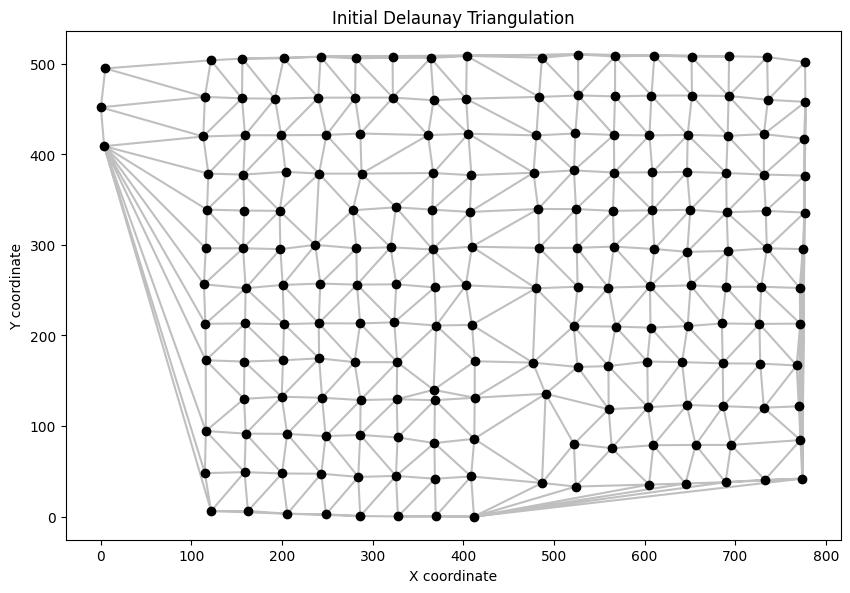

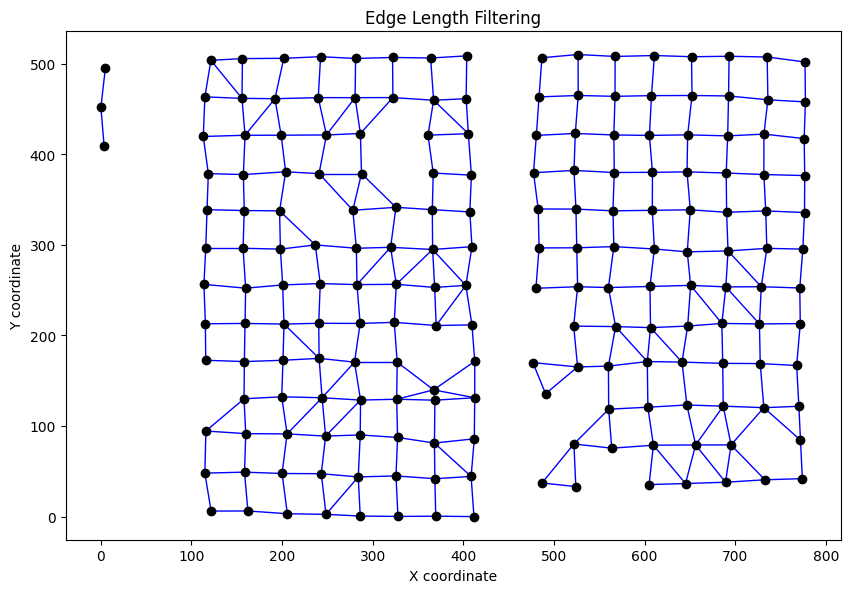

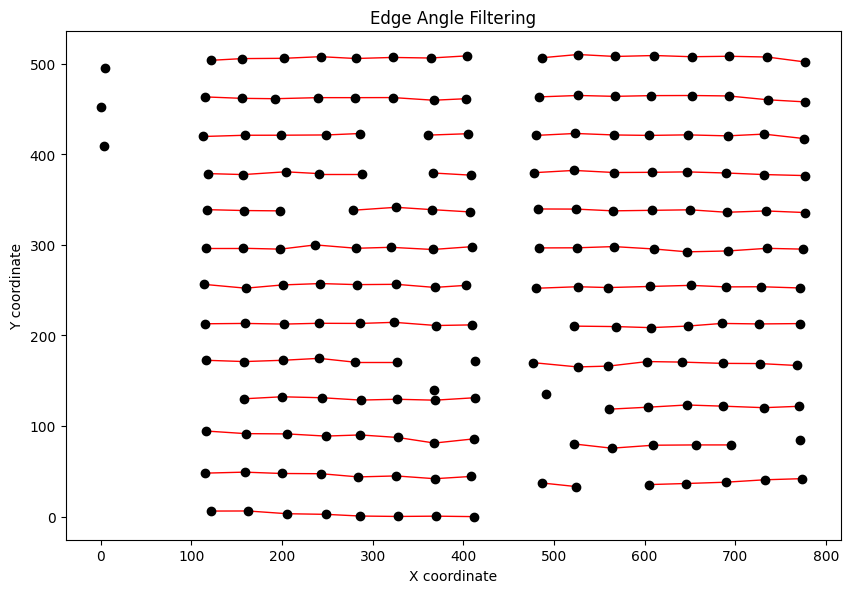

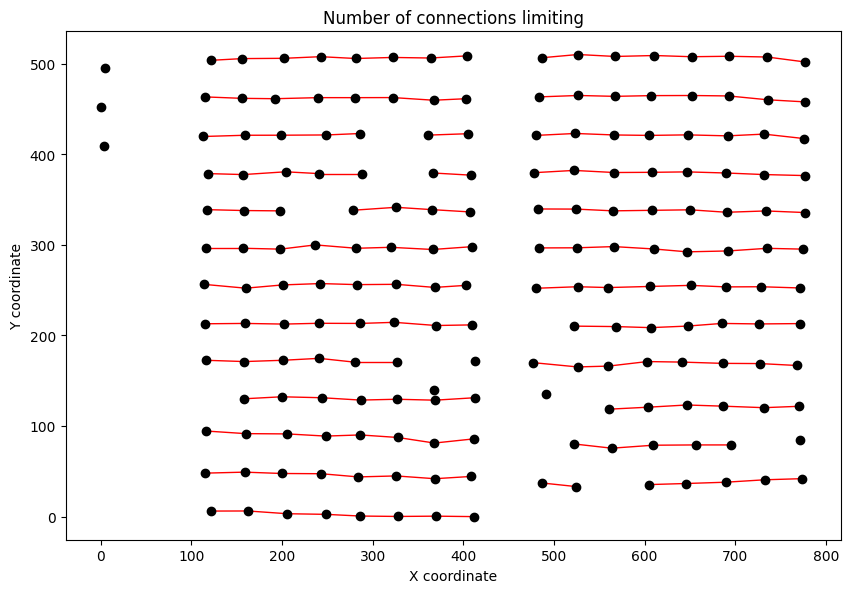

In [34]:

traveling_algorithm_input = limit_connections(angle_filtered_edges, normalized_coordinates)

visualize_delaunay_triangulation(normalized_coordinates, triangulation)
visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)
visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)
visualize_final_output(normalized_coordinates, traveling_algorithm_input)

In [ ]:
import matplotlib.pyplot as plt

def plot_rows_with_labels(rows):
    """
    Plots each row with labels indicating row and column numbers and distinguishes between real and imaginary points,
    with better label management to avoid overlapping.

    Parameters:
    rows (list of list of dicts): List where each sublist represents a row of points (centroids),
                                  and each point is a dictionary containing 'point', 'index', and 'is_imaginary'.
    """
    # Create a larger plot to better accommodate labels
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Define colors and markers
    real_point_color = 'blue'
    imaginary_point_color = 'red'

    # Plot each point and add a label
    for row_idx, row in enumerate(rows):
        for col_idx, point_info in enumerate(row):
            x, y = point_info['point']
            is_imaginary = point_info['is_imaginary']
            color = imaginary_point_color if is_imaginary else real_point_color
            ax.plot(x, y, 'o', color=color)  # Use 'o' for both real and imaginary for uniformity
            
            # Offset for text label to reduce overlap, adjust as needed
            offset = 5
            ha = 'right' if col_idx % 2 == 0 else 'left'
            va = 'bottom' if row_idx % 2 == 0 else 'top'
            ax.text(x + offset if ha == 'right' else x - offset, 
                    y + offset if va == 'bottom' else y - offset, 
                    f'R{row_idx}C{col_idx}',
                    fontsize=8, ha=ha, va=va, color=color)

    # Set plot labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Rows with Labels')

    # Show grid
    ax.grid(True)

    # Create a legend for real and imaginary points
    real_legend = plt.Line2D([0], [0], marker='o', color=real_point_color, label='Real Points', markersize=5)
    imaginary_legend = plt.Line2D([0], [0], marker='o', color=imaginary_point_color, label='Imaginary Points', markersize=5)
    ax.legend(handles=[real_legend, imaginary_legend])

    # Adjust axis limits to make sure all points are visible
    all_x = [point_info['point'][0] for row in rows for point_info in row]
    all_y = [point_info['point'][1] for row in rows for point_info in row]
    ax.set_xlim([min(all_x) - 10, max(all_x) + 10])
    ax.set_ylim([min(all_y) - 10, max(all_y) + 10])

    # Show the plot
    plt.show()


In [ ]:
def is_subarray(main_array, target_array):
    for subarray in main_array:
        if np.allclose(subarray, target_array, atol=1e-2):
            return True
    return False


In [ ]:
def rotate(point, angle, image_size):

    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    origin = (image_size[0] / 2, image_size[1] / 2)

    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

angle_degrees = -image_rotation

# Rotate all coordinates
rotated_coordinates = np.array([rotate(point, math.radians(-30), (1024,1024)) for point in normalized_coordinates])

# convert traveling_algorithm_input to the actual coordinates
rotated_coordinates_input = [(rotated_coordinates[start], rotated_coordinates[end]) for start, end in traveling_algorithm_input]
coordinates_input = [(normalized_coordinates[start], normalized_coordinates[end]) for start, end in traveling_algorithm_input]



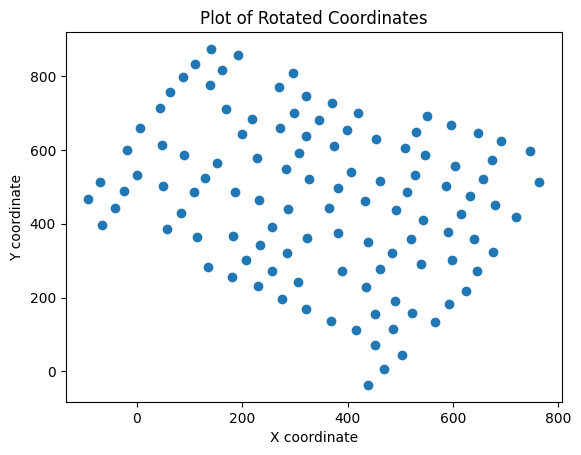

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(rotated_coordinates[:, 0], rotated_coordinates[:, 1])
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Plot of Rotated Coordinates')
plt.show()


57.107697179437196


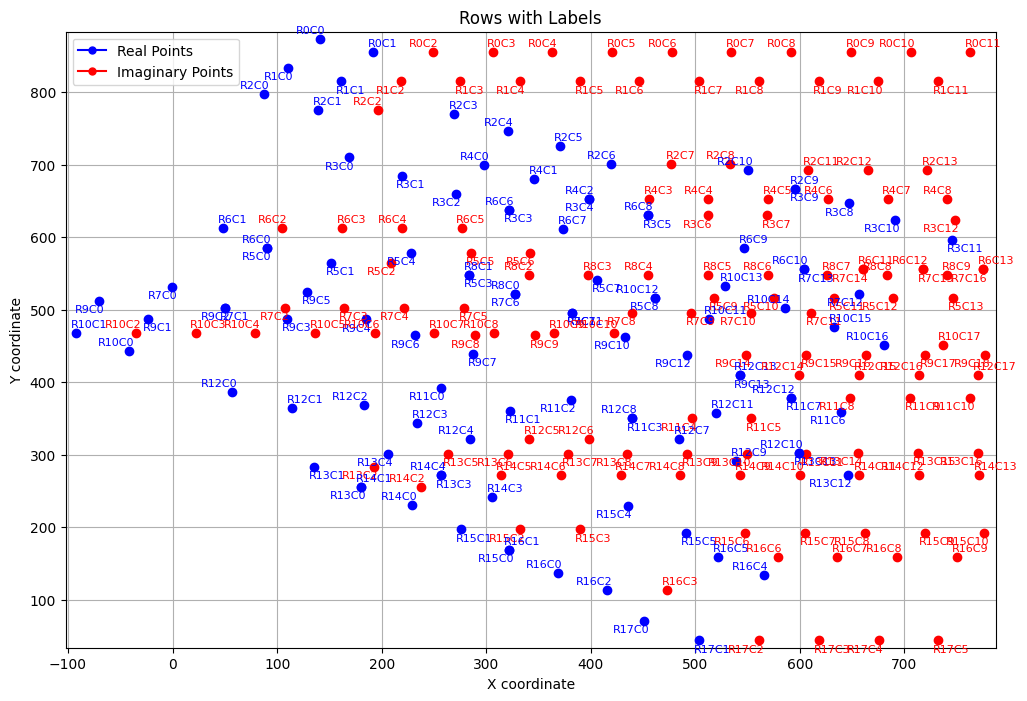

In [ ]:
import numpy as np
from itertools import combinations


average_distances = []
for edge in rotated_coordinates_input:
    start, end = edge
    distance = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    average_distances.append(distance)

average_distance = np.median(average_distances)

def calculate_grid_width(centers, d):
    """Calculate Y based on the maximum X value of the core + 1.5 * d."""
    max_x = max(centers, key=lambda x: x[0])[0]
    return max_x + 0.5 * d


# Calculate the average core-to-core distance
d = average_distance

# Calculate Y
image_width = calculate_grid_width(rotated_coordinates, 2 * d)

print(average_distance)

rows = traveling_algorithm(rotated_coordinates_input, image_width, d, 0.75 * d, 360, 0, 0.75)
sorted_rows = sorted(rows, key=lambda row: -row[0]['point'][1])


# Plot the sorted rows
plot_rows_with_labels(sorted_rows)


In [ ]:
point = sorted_rows[6][8]['point']
print(point)


[454.6274897  630.15395091]


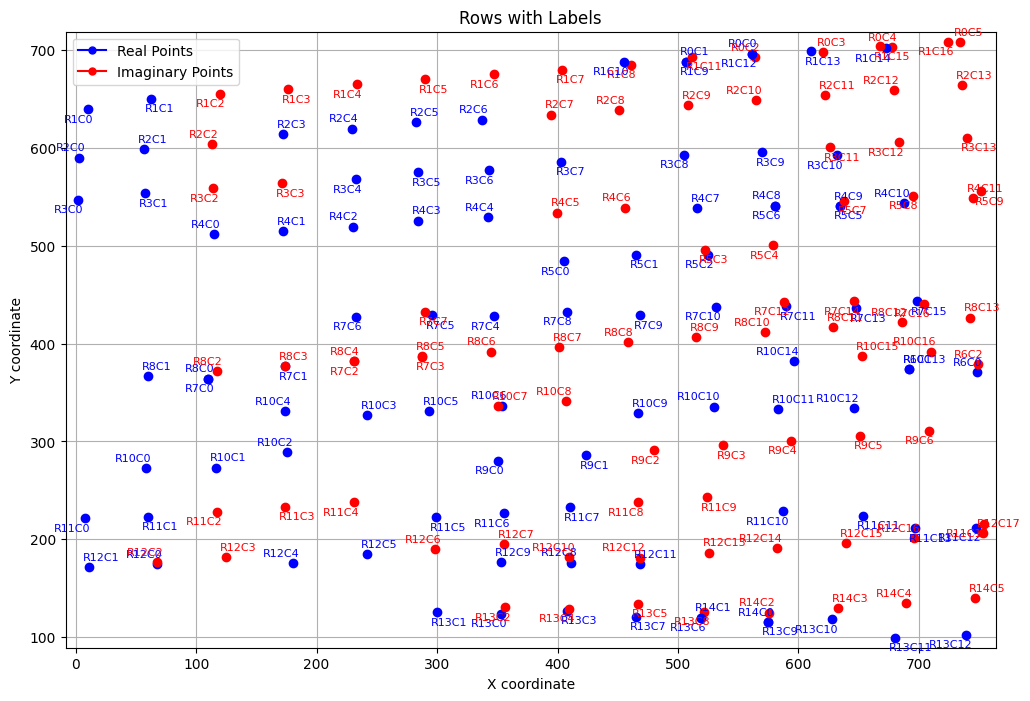

In [ ]:
import numpy as np
from itertools import combinations


average_distances = []
for edge in coordinates_input:
    start, end = edge
    distance = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    average_distances.append(distance)

average_distance = np.median(average_distances)

def calculate_grid_width(centers, d):
    """Calculate Y based on the maximum X value of the core + 1.5 * d."""
    max_x = max(centers, key=lambda x: x[0])[0]
    return max_x + 0.5 * d


# Calculate the average core-to-core distance
d = average_distance

# Calculate Y
image_width = calculate_grid_width(normalized_coordinates, 1.5 * d)


rows = traveling_algorithm(coordinates_input, image_width, d, 0.75 * d, 360, image_rotation, 0.75)
sorted_rows = sorted(rows, key=lambda row: -row[0]['point'][1])


# Plot the sorted rows
plot_rows_with_labels(sorted_rows)


In [ ]:
sorted_rows[1][1]

{'point': array([ 62.56258171, 650.10461883]),
 'index': -29,
 'is_imaginary': False}

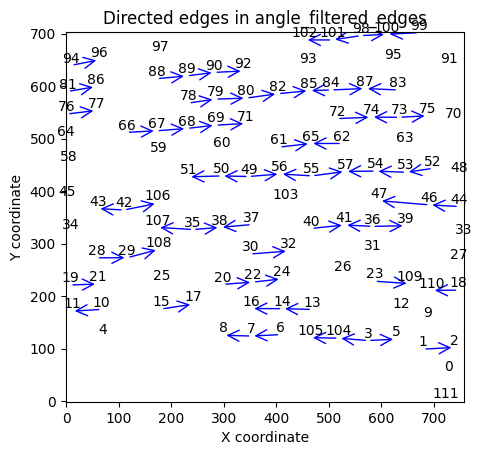

In [ ]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the arrows using FancyArrowPatch
for (start, end) in traveling_algorithm_input:
    start = normalized_coordinates[start]
    end = normalized_coordinates[end]
    # Create an arrow patch
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=20, color='b')

    # Add it to the axis
    ax.add_patch(arrow)

# Label the points with their indices
for i, coord in enumerate(normalized_coordinates):
    ax.text(coord[0], coord[1], str(i), ha='center', va='bottom')

# Set the plot title and labels
ax.set_title('Directed edges in angle_filtered_edges')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Set the same scale for both axes and set the limit
ax.set_aspect('equal')
ax.set_xlim([min(x[0] for x in normalized_coordinates)-1, max(x[0] for x in normalized_coordinates)+1])
ax.set_ylim([min(y[1] for y in normalized_coordinates)-1, max(y[1] for y in normalized_coordinates)+1])

# Show the plot
plt.show()


In [ ]:
traveling_algorithm_input

[(55, 57),
 (73, 75),
 (42, 106),
 (67, 68),
 (98, 101),
 (99, 100),
 (84, 87),
 (69, 71),
 (14, 16),
 (40, 41),
 (49, 56),
 (29, 108),
 (49, 50),
 (104, 105),
 (19, 21),
 (68, 69),
 (13, 14),
 (62, 65),
 (3, 104),
 (55, 56),
 (15, 17),
 (50, 51),
 (98, 100),
 (73, 74),
 (35, 38),
 (101, 102),
 (46, 47),
 (20, 22),
 (78, 79),
 (80, 82),
 (10, 11),
 (1, 2),
 (18, 110),
 (83, 87),
 (36, 39),
 (28, 29),
 (37, 38),
 (94, 96),
 (23, 109),
 (30, 32),
 (54, 57),
 (88, 89),
 (79, 80),
 (72, 74),
 (6, 7),
 (81, 86),
 (42, 43),
 (82, 85),
 (90, 92),
 (3, 5),
 (84, 85),
 (44, 46),
 (52, 53),
 (35, 107),
 (61, 65),
 (22, 24),
 (89, 90),
 (66, 67),
 (76, 77),
 (53, 54),
 (36, 41),
 (7, 8)]

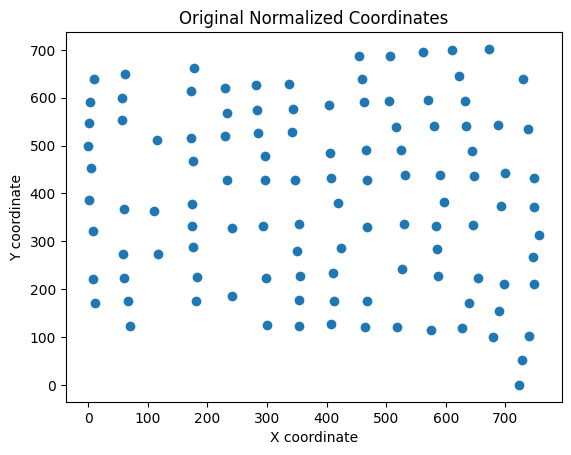

In [ ]:
import matplotlib.pyplot as plt

# Plot the original normalized coordinates
plt.scatter(normalized_coordinates[:, 0], normalized_coordinates[:, 1])

# Set the plot title and labels
plt.title('Original Normalized Coordinates')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Show the plot
plt.show()


In [ ]:
coordinates_input

[(array([468.29515114, 429.12949574]), array([531.45263993, 437.63539002])),
 (array([634.42775197, 540.73416899]), array([687.94903482, 543.58639625])),
 (array([110.04243926, 364.14955454]), array([173.78971536, 377.        ])),
 (array([171.97990959, 514.96329026]), array([230.0248994 , 519.49032229])),
 (array([561.25514348, 696.26074095]), array([506.78971536, 688.        ])),
 (array([672.25834418, 701.90860152]), array([610.59567295, 698.75567869])),
 (array([504.83322647, 592.74955612]), array([569.44206546, 595.54336537])),
 (array([284.26642263, 525.67754326]), array([342.54945734, 528.93107029])),
 (array([411.54270936, 176.2302353 ]), array([352.863996  , 176.43787068])),
 (array([466.9225648, 329.0566791]), array([530.11618741, 335.55315292])),
 (array([347.55609052, 427.94796658]), array([407.48503047, 432.70361042])),
 (array([116.38606953, 273.32486979]), array([175.78971536, 289.        ])),
 (array([347.55609052, 427.94796658]), array([296.04081517, 429.02193416])),
 

In [ ]:
len(traveling_algorithm_input)

62